# Тестовое задание
Ваша задача написать пайплайн для тренировки модели глубоко обучения (любую – **embeddings + LSTM, Bert** …) с использованием следующих инструментов: pytorch, sklearn, matplotlib – для решения задачи **NER** (извлечения сущностей).

В качестве данных используется датасет **Conll2003** с четырьмя классами **Per, Org, Loc, Misc** в формате **Conll**.

В тетрадке ниже заданы основные классы и функции для построения требуемого пайплайн, какие-то уже имплементированы, какие-то – нет. Их требуется доработать. Тем не менее если данный набор абстракций вам не подходит Вы можете написать свой пайплайн «с нуля», однако обоснованность у этих действий должна быть.

### Что оценивается в первую очередь:

* Выбранная архитектура для решения задачи
* Выбранные предобученные веса
* Полученные метрики
### Затем:

* Глубина разведочного анализа
* Какая схема теггирования используется (**BIO, IO** или другие)
* Каким образом производится расчет метрик (потокенный отчет, отчет по точному совпадению спанов сущностей)
### С меньшим приоритетом:

* Скорость предобработки и постобработки данных
* Стиль кода

## Импорт данных, модулей и библиотек

In [ ]:
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testb
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train

--2022-02-15 20:10:40--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 827012 (808K) [text/plain]
Saving to: ‘eng.testa’

eng.testa           100%[===================>] 807.63K  --.-KB/s    in 0.02s   

2022-02-15 20:10:41 (44.7 MB/s) - ‘eng.testa’ saved [827012/827012]

--2022-02-15 20:10:41--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 748096 (731K) [text/plain]
Sa

In [ ]:
!head eng.train

-DOCSTART- -X- O O

EU NNP I-NP I-ORG
rejects VBZ I-VP O
German JJ I-NP I-MISC
call NN I-NP O
to TO I-VP O
boycott VB I-VP O
British JJ I-NP I-MISC
lamb NN I-NP O


In [ ]:
!pip install -q transformers

     |████████████████████████████████| 3.5 MB 14.2 MB/s 
     |████████████████████████████████| 596 kB 59.5 MB/s 
     |████████████████████████████████| 6.8 MB 68.1 MB/s 
     |████████████████████████████████| 67 kB 4.3 MB/s 
     |████████████████████████████████| 895 kB 65.7 MB/s 


In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from typing import List
from collections import Counter
import pandas as pd
from pandas.core import series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, classification_report
from transformers import AutoTokenizer, AutoModelForTokenClassification, get_linear_schedule_with_warmup, pipeline
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path  = '/content/drive/MyDrive/'

Mounted at /content/drive


In [ ]:
t = '%-14s%-s'
libs = [('pandas', pd.__version__), ('numpy', np.__version__), ('sklearn', __import__('sklearn').__version__), \
        ('torch', torch.__version__), ('transformers', __import__('transformers').__version__)]

for lib in libs:
    print(t % lib)

pandas        1.3.5
numpy         1.21.5
sklearn       1.0.2
torch         1.10.0+cu111
transformers  4.16.2


## Разведочный анализ данных

#### Функции, используемые в РАД

In [ ]:
def read_data(file):
    lines = open(file, "r").readlines()
    data = {"sentences": [], "labels_per_sent": []}
    sentence, labels = [], []

    for line in tqdm(lines):
        line = line.strip()
        if not line:
            if sentence and labels:
                assert len(sentence) == len(labels)
                data["sentences"].append(sentence)
                data["labels_per_sent"].append(labels)
                sentence, labels = [], []
            continue
        if line.startswith("-DOCSTART-"):
            continue
        else:
            values = line.split(" ")
            try:
                token, _, _, label = values
                sentence.append(token)
                if label != 'O':
                    labels.append(label.split('-')[-1])
                else:
                    labels.append(label)

            except Exception as e:
                print(f"Error has occur: {e}")
                continue
    return data


def get_counts_sort_by_length(length_list, sort_index=True, top_k=20, asc=False):
    if sort_index:
        series = pd.Series(length_list).value_counts(ascending=asc).sort_index(ascending=asc).head(top_k)
        return pd.DataFrame({'count_tokens': series.index, 'count_sentences': series.values})
    else:
        series = pd.Series(length_list).value_counts(ascending=asc).head(top_k)
        return pd.DataFrame({'count_tokens': series.index, 'count_sentences': series.values})


def get_label_distribution(labels: List[List[str]]):
    labels = [label for labels_per_sent in labels for label in labels_per_sent]
    return Counter(labels)


def visualize_distr(data: Counter, mode: str):
    labels = list(data.keys())
    plt.bar(x=labels, height=list(data.values()))
    plt.title(f"{mode} distribution")
    plt.show()


def get_tags_and_counts(distribution):
    del distribution['O']                                   # удаляем 'O'
    tags = list(distribution.keys())               # извлекаем сущности из трейн-части
    counts = list(distribution.values())
    return zip(*sorted(zip(tags, counts)))


def diagram(dia_type, labels, counts, figsize=(8, 4), **kwargs):
    if 'color' in kwargs and kwargs['color']:
        colors = list(map(lambda x: 'tab:' + x, ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']))
    
    class_data = ['train', 'valid']
    fig, axes = plt.subplots(1, 2, figsize=figsize)  
                                                              
    for j, ax in enumerate(axes.flat):       
        ax.set_title(class_data[j])
        if dia_type == 'bar':
            ax.bar(labels[j], counts[j], color=colors)
        elif dia_type == 'pie':                    
            ax.pie(counts[j], labels=labels[j], autopct='%1.1f%%', startangle=90)
        else:
            raise NameError("Выберите 'bar' или 'pie'")

    plt.tight_layout()
    plt.show()


def bio_tagger(tags):
      bio_tagged = []
      prev_tag = "O"
      for tag in tags:
          if tag == "O":                            # O
              bio_tagged.append(tag)
              prev_tag = tag
              continue
          if tag != "O" and prev_tag == "O":        # Begin NE
              bio_tagged.append("B-" + tag)
              prev_tag = tag
          elif prev_tag != "O" and prev_tag == tag: # Inside NE
              bio_tagged.append("I-" + tag)
              prev_tag = tag
          elif prev_tag != "O" and prev_tag != tag: # Adjacent NE
              bio_tagged.append("B-" + tag)
              prev_tag = tag
      return bio_tagged

#### Распределение (дефолтное) по числу токенов в предложении

In [ ]:
train = read_data("eng.train")
valid = read_data("eng.testa")
test = read_data("eng.testb")

  0%|          | 0/219554 [00:00<?, ?it/s]

  0%|          | 0/55045 [00:00<?, ?it/s]

  0%|          | 0/50351 [00:00<?, ?it/s]

In [ ]:
length_sentences = [len(sent) for sent in train["sentences"] + valid["sentences"]]

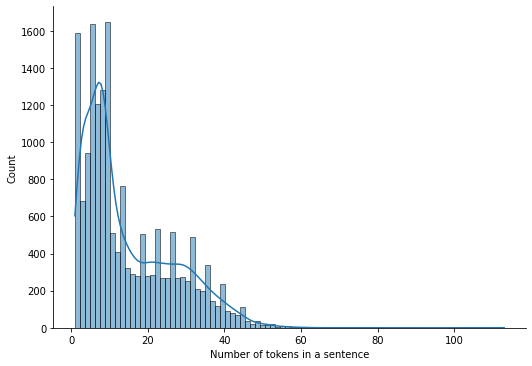

In [ ]:
sns.displot(length_sentences, kde=True, aspect=1.5)
plt.xlabel("Number of tokens in a sentence")
plt.show()

In [ ]:
print(f'Самое длинное предложение {max(length_sentences)} токенов')
print(f'Самое короткое предложение {min(length_sentences)} токен')

Самое длинное предложение 113 токенов
Самое короткое предложение 1 токен


In [ ]:
get_counts_sort_by_length(length_sentences)

,count_tokens,count_sentences
0,113,1
1,109,1
2,105,1
3,93,1
4,91,1
5,83,1
6,79,1
7,78,1
8,75,1
9,67,1


#### Распределение по классам исходных токенов в предложениях

In [ ]:
valid["sentences"][0], valid["labels_per_sent"][0]

(['CRICKET',
  '-',
  'LEICESTERSHIRE',
  'TAKE',
  'OVER',
  'AT',
  'TOP',
  'AFTER',
  'INNINGS',
  'VICTORY',
  '.'],
 ['O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

In [ ]:
train_distribution = get_label_distribution(train["labels_per_sent"])
valid_distribution = get_label_distribution(valid["labels_per_sent"])

In [ ]:
train_distribution, valid_distribution

(Counter({'LOC': 8297, 'MISC': 4593, 'O': 169578, 'ORG': 10025, 'PER': 11128}),
 Counter({'LOC': 2094, 'MISC': 1268, 'O': 42759, 'ORG': 2092, 'PER': 3149}))

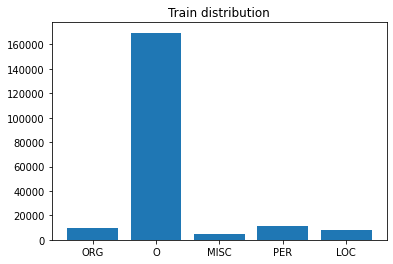

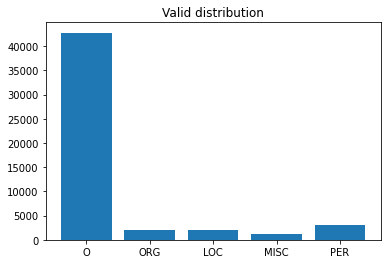

In [ ]:
visualize_distr(train_distribution, 'Train')
visualize_distr(valid_distribution, 'Valid')

Посмотрим на баланс классов целевых сущностей (без 'O')

In [ ]:
ne_tags_train, counts_ne_tags_train = get_tags_and_counts(train_distribution)
ne_tags_valid, counts_ne_tags_valid = get_tags_and_counts(valid_distribution)

In [ ]:
ne_tags = [ne_tags_train, ne_tags_valid]
counts_ne_tags = [counts_ne_tags_train, counts_ne_tags_valid]

In [ ]:
print(ne_tags, counts_ne_tags)

[('LOC', 'MISC', 'ORG', 'PER'), ('LOC', 'MISC', 'ORG', 'PER')] [(8297, 4593, 10025, 11128), (2094, 1268, 2092, 3149)]


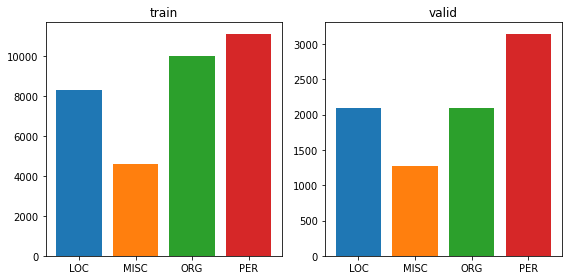

In [ ]:
diagram('bar', ne_tags, counts_ne_tags, (8, 4), color=True)

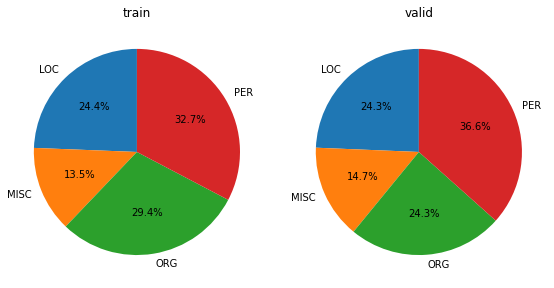

In [ ]:
diagram('pie', ne_tags, counts_ne_tags,  (8, 4))

Сильного дисбаланса в данных не наблюдается

#### Посмотрим на распределения после BIO-тегирования

In [ ]:
# Получим тегированные лейблы для данных
train["labels_per_sent"] = [bio_tagger(labs) for labs in train["labels_per_sent"]]
valid["labels_per_sent"] = [bio_tagger(labs) for labs in valid["labels_per_sent"]]
test["labels_per_sent"] = [bio_tagger(labs) for labs in test["labels_per_sent"]]

Посмотрим, как тегировались лейблы

In [ ]:
print(train["labels_per_sent"][0], train['sentences'][0])

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'] ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']


И распределение новых классов

In [ ]:
train_distribution = get_label_distribution(train["labels_per_sent"])
valid_distribution = get_label_distribution(valid["labels_per_sent"])

ne_tags_train, counts_ne_tags_train = get_tags_and_counts(train_distribution)
ne_tags_valid, counts_ne_tags_valid = get_tags_and_counts(valid_distribution)

ne_tags = [ne_tags_train, ne_tags_valid]
counts_ne_tags = [counts_ne_tags_train, counts_ne_tags_valid]

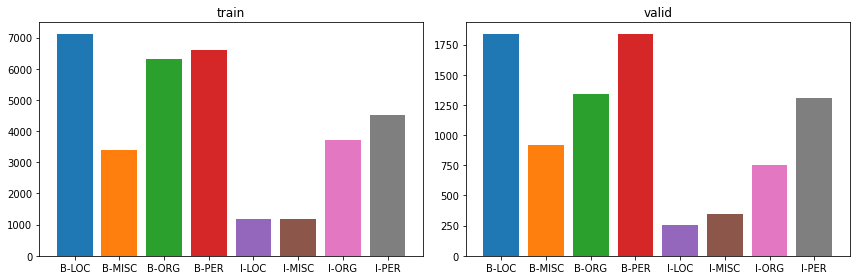

In [ ]:
diagram('bar', ne_tags, counts_ne_tags, (12, 4), color=True)

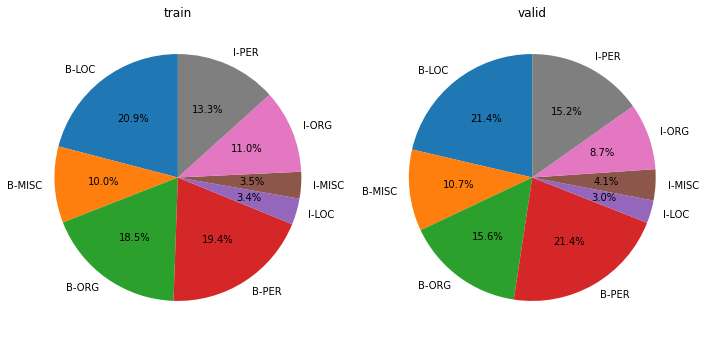

In [ ]:
diagram('pie', ne_tags, counts_ne_tags, (10, 6))

#### Посмотрим, как изменится разбиение при использовании bert-токенизатора

In [ ]:
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Посмотрим, как изменятся длины предложений после токенизации

In [ ]:
new_length_sentences = list(map(len, map(tokenizer.tokenize, map(' '.join, train['sentences'] + valid['sentences']))))

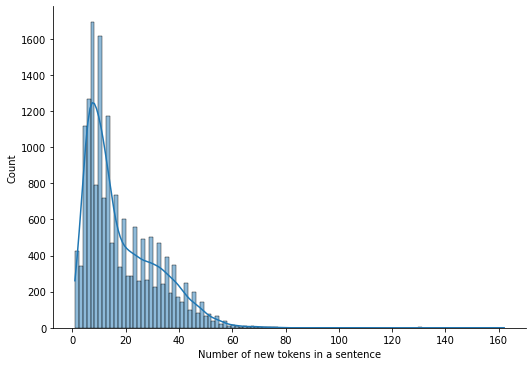

In [ ]:
sns.displot(new_length_sentences, kde=True, aspect=1.5)
plt.xlabel("Number of new tokens in a sentence")
plt.show()

In [ ]:
print(f'Максимальное и минимальное число токенов: {max(new_length_sentences), min(new_length_sentences)}')

Максимальное и минимальное число токенов: (162, 1)


Максимальное число токенов увеличилось с 113 до 162 в силу особенности используемого токенизатора, который разбивает неизвестные слова на известные под слова. Далее в модели будем использовать параметр max_length = 170 с учётом полученной информации, чтобы не дополнять предложения большим числом паддингов.

In [ ]:
get_counts_sort_by_length(new_length_sentences)

,count_tokens,count_sentences
0,162,1
1,144,1
2,131,1
3,130,1
4,126,1
5,111,1
6,105,1
7,95,1
8,87,1
9,84,1


## Модель и обучение

#### Используемые классы и функции

In [ ]:
class NERDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=170):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.labels = np.unique([x for y in self.data["labels_per_sent"] for x in y])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        self.spec_tok2num = {'[CLS]': -100, '[SEP]': -100, '[PAD]': -100, '[FIL]': -100} # CrossEntropyLoss фильтрует индекс -100 по умолчанию


    def _getlabelmaping(self, default_labels_per_sent, offset):
        labels_per_sent = ['[CLS]'] + default_labels_per_sent + ['[SEP]']
        labels_per_sent.extend(['[PAD]']*(self.max_length - len(labels_per_sent)))
        # Поставим в соответствие исходные лейблы токенов заново токенизированым.
        # Расставим их тем новым токенам, у который первый символ имеет позицию 0: (0, end)
        new_labels = []

        i = 0
        for pos in offset:
            if pos[0] == 0:
                new_labels.append(labels_per_sent[i])
                i += 1
            else:
                new_labels.append('[FIL]') # Непервые подслова заполняем токеном [FIL]

        target = [self.label2num[l] if '[' not in l else self.spec_tok2num[l] for l in new_labels]
        
        return target


    def __getitem__(self, index):
        tokenizer_output = self.tokenizer.encode_plus(
                            self.data['sentences'][index],
                            None,
                            add_special_tokens=True,
                            max_length=self.max_length,
                            is_split_into_words=True,
                            padding='max_length',
                            return_special_tokens_mask=True,
                            return_offsets_mapping=True
        )

        # Воспользуемся offset_mapping для отслеживания разбитых токенайзером слов на подслова.
        # offset = tokenizer_output['offset_mapping'] --> [(0, 0), (0, 3), (3, 5), ...]          
        target = self._getlabelmaping(
                        self.data["labels_per_sent"][index],
                        tokenizer_output['offset_mapping'])
        
        """
        # invert special_tokens_mask
        neg_mask = torch.tensor([1, 1, 0, 0])
        pos_mask = torch.abs(neg_mask - torch.ones_like(neg_mask))
        print(pos_mask) # tensor([0, 0, 1, 1])
        """
        
        return {
            "input_ids": torch.tensor(tokenizer_output['input_ids'], dtype=torch.long).squeeze(0),
            "attention_mask": torch.tensor(tokenizer_output['attention_mask'], dtype=torch.long).squeeze(0),
            "special_tokens_mask": torch.tensor(tokenizer_output['special_tokens_mask'], dtype=torch.long).squeeze(0),
            "labels": torch.tensor(target, dtype=torch.long).squeeze(0) 
        }


    def __len__(self):
        return len(self.data["sentences"])

In [ ]:
class NERModel(nn.Module):
    def __init__(self, pretrained_model, tokenizer):
        super().__init__()
        self.bert = pretrained_model
        self.tokenizer = tokenizer


    def predict(self, text, device, is_split_into_words=True):
        num2label = {0: 'B-LOC', 1: 'B-MISC', 2: 'B-ORG', 3: 'B-PER', \
                     4: 'I-LOC', 5: 'I-MISC', 6: 'I-ORG', 7: 'I-PER', 8: 'O'}

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            return_token_type_ids=False,
            truncation=True,
            is_split_into_words=is_split_into_words,
            return_attention_mask=True,
            return_tensors='pt',
            return_offsets_mapping=True
        )
        
        out = {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }
        
        input_ids = out["input_ids"].to(device)
        attention_mask = out["attention_mask"].to(device)
        # Убираем [CLS] и [SEP] токены при выводе
        offset_mapping = encoding["offset_mapping"][0].cpu().numpy()[1: -1]
        

        outputs = self.bert(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        # Убираем [CLS] и [SEP] токены при выводе
        prediction = torch.argmax(outputs.logits, dim=2).cpu().numpy()[0][1: -1]
        # [(num, tag), ...] без деления токены на подтокены для сравнения с оригиналом
        tags = [(p, num2label[p]) for p, pos in zip(prediction, offset_mapping) if pos[0] == 0]   
        # Токенизироавнный текст токенизатором, предсказания, [(num, ...), (tag, ...)]
        return tokenizer.convert_ids_to_tokens(input_ids), prediction, list(zip(*tags))
    

    def forward(self, inputs, attention_mask, labels):         
        outputs = self.bert(input_ids=inputs,
                            attention_mask=attention_mask, 
                            labels=labels)
        
        return outputs[0], outputs[1] # loss, probs

In [ ]:
def transform_logits(predictions: List[torch.tensor]):
    return np.argmax(predictions.detach().cpu().numpy(), axis=2).flatten()


def transform_target(target_labels: List[torch.tensor]):
    return target_labels.to('cpu').numpy().flatten()


def count_metrics(gold_labels_per_sentence: List[List[str]], predict_labels_per_sentence: List[List[str]], last_epoch=False):
    gold_labels = np.array([l for l_per_sent in gold_labels_per_sentence for l in l_per_sent])
    predict_labels = np.array([l for l_per_sent in predict_labels_per_sentence for l in l_per_sent])
    mask = (gold_labels != -100)
    
    gold_labels = gold_labels[mask]
    predict_labels = predict_labels[mask]
    if last_epoch:
        print(classification_report(gold_labels, predict_labels, target_names=list(valid_dataset.label2num.keys())))

    return f1_score(gold_labels, predict_labels, average='macro')


def test_score(model, test_data, device):
    pred = [t for sent in test_data.data['sentences'] for t in model.predict(sent, device)[2][0]]    
    y_true = [test_data.label2num[i] for sent in test_data.data['labels_per_sent'] for i in sent]
    return f1_score(y_true, pred, average='macro')


def loss_plot(tr_loss, val_loss):
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.plot(range(1, epochs + 1), tr_loss, label='Mean epoch train loss')
    ax.plot(range(1, epochs + 1), val_loss,  label='Mean epoch valid loss')
    ax.set_xlabel('Epoch')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()
    plt.show()

In [ ]:
def train_loop(model, dataloader, optimizer, scheduler, clip, device):
    epoch_loss = 0  # Кумулятивный по батчам лосс за эпоху
    model.train()

    for i, train_batch in enumerate(tqdm(dataloader)):

        input_ids = train_batch['input_ids'].to(device)
        attention_mask = train_batch['attention_mask'].to(device)
        labels = train_batch['labels'].to(device)

        optimizer.zero_grad()
        loss, logits = model.forward(input_ids, attention_mask, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()
    return epoch_loss/(i+1)


def eval_loop(model, dataloader, device, last_epoch=False):
    epoch_loss = 0  # Кумулятивный по батчам лосс за эпоху
    predict_labels, gold_labels = [], []
    model.eval()

    for i, valid_batch in enumerate(tqdm(dataloader)):

        with torch.no_grad():
            input_ids = valid_batch['input_ids'].to(device)
            attention_mask = valid_batch['attention_mask'].to(device)
            labels = valid_batch['labels'].to(device)
            
            loss, logits = model.forward(input_ids, attention_mask, labels)
            epoch_loss += loss.item()

            gold_labels.append(transform_target(labels))
            predict_labels.append(transform_logits(logits))

    score = count_metrics(gold_labels, predict_labels, last_epoch)
    return epoch_loss/(i+1), score


def fit(model, train_loop, eval_loop, tr_loader, val_loader, optimizer, scheduler, epochs, clip, device, model_save_path=path+'best-val-ner-model.pt', return_output=True):
    model = model.to(device)
    # Для отрисовки графиков обучения
    best_loss_valid = float('inf')
    train_history = []    # Средний по батчам лосс для каждой эпохи
    valid_history = []    # - // - // -
    score_history = []
    last_epoch = False

    for epoch in range(1, epochs + 1):
        if epoch == epochs:
            last_epoch = True

        print(f"Start epoсh №{epoch}")

        epoch_loss_train = train_loop(model, tr_loader, optimizer, scheduler, clip, device)
        epoch_loss_valid, score = eval_loop(model, val_loader, device, last_epoch=last_epoch)

        if epoch_loss_valid < best_loss_valid:
            best_loss_valid = epoch_loss_valid
            torch.save(model.state_dict(), model_save_path)

        train_history.append(epoch_loss_train)
        valid_history.append(epoch_loss_valid)
        score_history.append(score)

        print(f"End epoch №{epoch}\n\tTrain loss: {epoch_loss_train:.3f} | Valid loss: {epoch_loss_valid:.3f} | F1: {score:.3f}")
        print("_" * 70, end="\n")

    model.load_state_dict(torch.load(model_save_path, map_location=device))

    if return_output:    
        return {'train_losses': train_history, 
                'valid_losses': valid_history, 
                'f1_score': score_history}

#### Запуск обучение

In [ ]:
train_dataset = NERDataset(train, tokenizer)
valid_dataset = NERDataset(valid, tokenizer)
test_dataset = NERDataset(test, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [ ]:
print(f'Кодировка лейблов:\n{train_dataset.label2num}')

Кодировка лейблов:
{'B-LOC': 0, 'B-MISC': 1, 'B-ORG': 2, 'B-PER': 3, 'I-LOC': 4, 'I-MISC': 5, 'I-ORG': 6, 'I-PER': 7, 'O': 8}


Создадим модель с нужными параметрами

In [ ]:
epochs = 10
clip = 1

pretrained_model = AutoModelForTokenClassification.from_pretrained(checkpoint, num_labels=len(np.unique(ne_tags))+1)
model = NERModel(pretrained_model, tokenizer)
optimizer = optim.Adam(model.parameters(), lr=2e-5, betas=(0.9,0.999))
scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=len(train_dataloader) * epochs)

device = "cuda:0" if torch.cuda.is_available() else 'cpu'
print(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN t

cuda:0


Запустим обучение

In [ ]:
output = fit(model, 
             train_loop, eval_loop, 
             train_dataloader, valid_dataloader, 
             optimizer, 
             scheduler, 
             epochs, clip, device)

Start epoсh №1


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

End epoch №1
	Train loss: 0.273 | Valid loss: 0.070 | F1: 0.882
______________________________________________________________________
Start epoсh №2


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

End epoch №2
	Train loss: 0.057 | Valid loss: 0.053 | F1: 0.920
______________________________________________________________________
Start epoсh №3


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

End epoch №3
	Train loss: 0.035 | Valid loss: 0.050 | F1: 0.927
______________________________________________________________________
Start epoсh №4


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

End epoch №4
	Train loss: 0.025 | Valid loss: 0.051 | F1: 0.930
______________________________________________________________________
Start epoсh №5


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

End epoch №5
	Train loss: 0.018 | Valid loss: 0.051 | F1: 0.934
______________________________________________________________________
Start epoсh №6


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

End epoch №6
	Train loss: 0.014 | Valid loss: 0.054 | F1: 0.936
______________________________________________________________________
Start epoсh №7


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

End epoch №7
	Train loss: 0.012 | Valid loss: 0.055 | F1: 0.938
______________________________________________________________________
Start epoсh №8


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

End epoch №8
	Train loss: 0.010 | Valid loss: 0.056 | F1: 0.937
______________________________________________________________________
Start epoсh №9


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

End epoch №9
	Train loss: 0.009 | Valid loss: 0.057 | F1: 0.936
______________________________________________________________________
Start epoсh №10


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       B-LOC       0.96      0.97      0.97      1837
      B-MISC       0.91      0.89      0.90       918
       B-ORG       0.94      0.93      0.93      1341
       B-PER       0.98      0.98      0.98      1842
       I-LOC       0.94      0.90      0.92       257
      I-MISC       0.88      0.82      0.85       350
       I-ORG       0.91      0.89      0.90       751
       I-PER       0.99      0.99      0.99      1307
           O       0.99      1.00      1.00     42759

    accuracy                           0.99     51362
   macro avg       0.94      0.93      0.94     51362
weighted avg       0.99      0.99      0.99     51362

End epoch №10
	Train loss: 0.008 | Valid loss: 0.056 | F1: 0.936
______________________________________________________________________


In [ ]:
#model.load_state_dict(torch.load(path + 'best-val-ner-model.pt', map_location=device))
print(f'F1-score на тестовых данных: {test_score(model, test_dataset, device):.3f}')

F1-score на тестовых данных: 0.882


График обучения модели

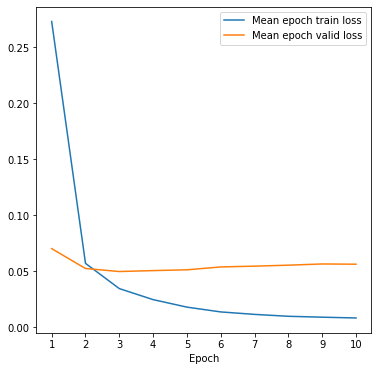

In [ ]:
loss_plot(output['train_losses'], output['valid_losses'])

## Заключение

Ключевым критерием в задаче NER является F1-метрика (macro), которая является средним гармоническим (компромиссным вариантом) между точностью и полнотой.

На 10 эпохах качество получилось около 0.94, на тесте 0.88. На графике можно заметить переобучение где-то с 6-й эпохи. Для увеличить качества можно подобрать лучше гиперпараметры или настроить планировщик. Кроме того, можно попробовать поискать другую архитектуру или, например, снимать скрытые состояния не только лишь с последнего слоя.